In [24]:
import geopandas
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:

# load LA neighborhood geo data
geojson_file_loc = "data/mapping-la-data-main/geojson/la-county-neighborhoods-v6.geojson"
geo_la_neighborhood = geopandas.read_file(geojson_file_loc)
# LA EPSG transformation
# geo_la_neighborhood = geo_la_neighborhood.to_crs('EPSG:6424')
geo_la_neighborhood["area"] = geo_la_neighborhood.area
geo_la_neighborhood['boundary'] = geo_la_neighborhood.boundary
geo_la_neighborhood['centroid'] = geo_la_neighborhood.centroid
# load LA neighborhood poplulation data
pop_la_neighborhood = pd.read_csv('data/la-neighborhood-population.csv')
# merge two dataframe together
df = geo_la_neighborhood.merge(pop_la_neighborhood, left_on='name', right_on='Neighborhood', how='inner')
del df['Neighborhood']
del df['kind']
del df['external_id']
del df['slug']
del df['set']
del df['metadata']
del df['resource_uri']
df = df.rename(columns={'Population per Sqmi':'pop_density'})
df['total_pop'] = df.apply(lambda x: 4000 * x['area'] * x['pop_density'], axis=1)


C:\Users\guanc\AppData\Local\Temp\ipykernel_11548\1125930513.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_la_neighborhood["area"] = geo_la_neighborhood.area
C:\Users\guanc\AppData\Local\Temp\ipykernel_11548\1125930513.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_la_neighborhood['centroid'] = geo_la_neighborhood.centroid


In [26]:
# load LA existing vertiport data
df_heliport = pd.read_csv('data/us-heliports-landing-facilities.csv')
del df_heliport['State_Name']
del df_heliport['Facility_Type']
del df_heliport['County_s_State_Post_Office_Code']
df_airport = pd.read_csv('data/us-general-aviation-airports.csv')
del df_airport['County_s_State_Post_Office_Code']
del df_airport['State_Name']
df_vertiport = pd.concat([df_heliport, df_airport])
mask = (df_vertiport['SHAPE_X'] <-117.6) & (df_vertiport['SHAPE_X'] > -119) & (df_vertiport['SHAPE_Y'] <34.8) & (df_vertiport['SHAPE_Y'] > 33.6)
df_vertiport_la = df_vertiport[mask]

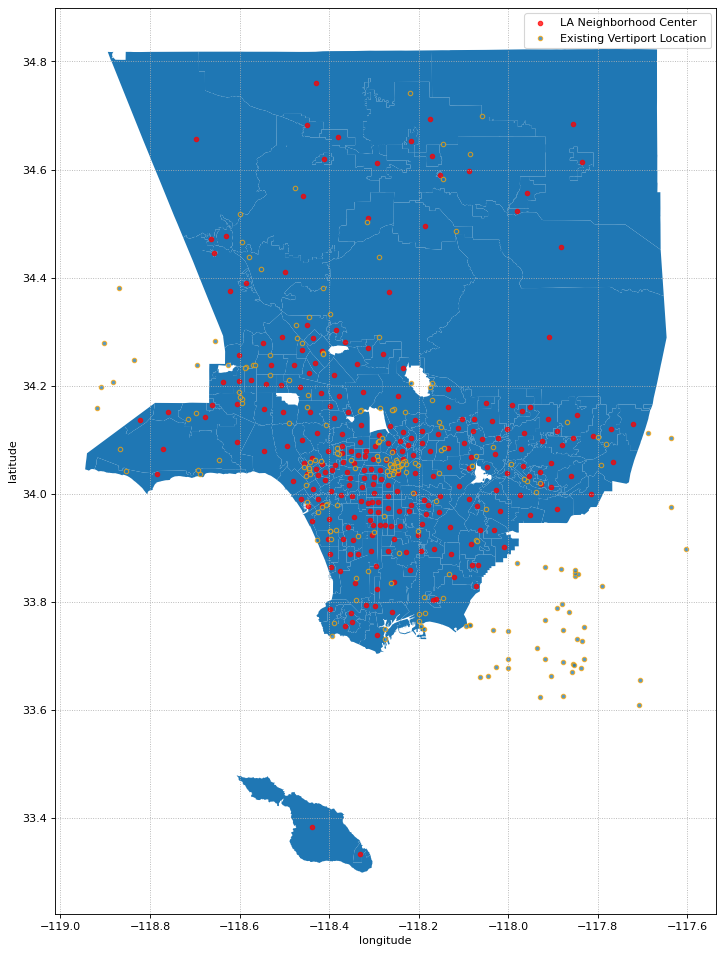

In [27]:

fig, ax = plt.subplots(figsize=(15,15), dpi=80)
df.plot(ax=ax, label='LA Neighborhood')
c = geopandas.GeoDataFrame(df, geometry=df['centroid'])
c.plot(ax=ax, color='red',alpha=0.75, markersize=16, label='LA Neighborhood Center')
ax.scatter(df_vertiport_la['SHAPE_X'], df_vertiport_la['SHAPE_Y'], s=16, edgecolors='orange', alpha=0.75, label='Existing Vertiport Location')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.legend()
ax.grid(linestyle=':')

In [28]:
from scipy.sparse import csr_matrix
df_centroid = pd.DataFrame(df[['name','centroid','total_pop']])
n = len(df_centroid)
df_centroid['idx'] = df_centroid.index
# Cartesian product to calculate distance between all centroid pairs
centroid_pair = df_centroid.merge(df_centroid, how='cross')
centroid_pair['distance']=centroid_pair.apply(lambda x: x['centroid_x'].distance(x['centroid_y']), axis=1)
centroid_pair['total_pop']=centroid_pair.apply(lambda x: x['total_pop_x'] + x['total_pop_y'], axis=1)
# distance matrix
D = csr_matrix((centroid_pair['distance'], (centroid_pair['idx_x'], centroid_pair['idx_y'])), shape=(n,n))
# population matrix
P = csr_matrix((centroid_pair['total_pop'], (centroid_pair['idx_x'], centroid_pair['idx_y'])), shape=(n,n))
P = P / np.max(P)


Text(0.5, 1.0, 'Find elbow point for K')

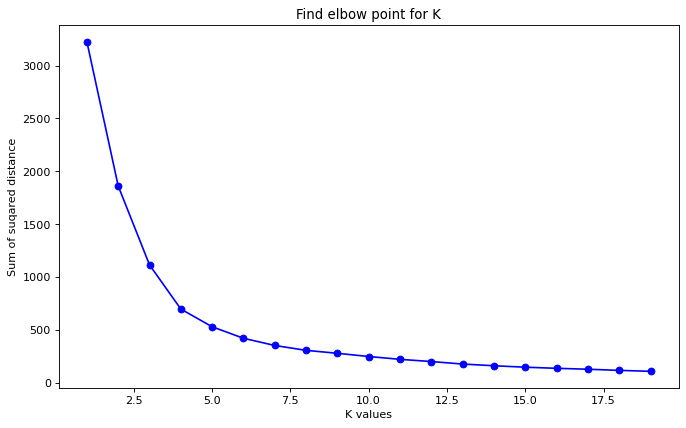

In [29]:
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
embedding = Isomap(n_neighbors=10,n_components=2)
D_transformed = embedding.fit_transform(D)

sum_of_squared_distiance=[]
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(D_transformed)
    sum_of_squared_distiance.append(kmeans.inertia_)
fig, ax = plt.subplots(1,1,figsize=(10,6), dpi=80)
ax.plot(K,sum_of_squared_distiance,'bo-')
ax.set_xlabel('K values')
ax.set_ylabel('Sum of suqared distance')
ax.set_title('Find elbow point for K')

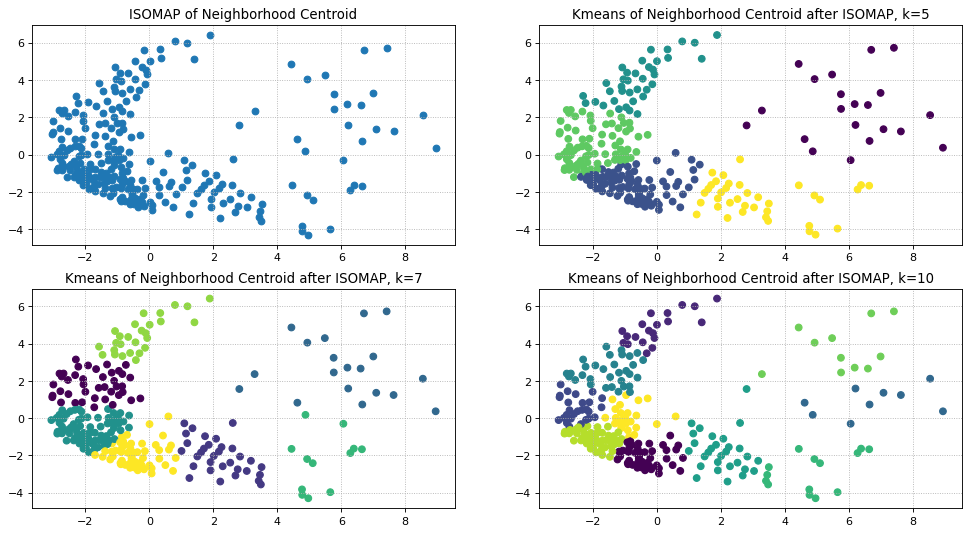

In [30]:


fig, ax = plt.subplots(2,2,figsize=(15,8), dpi=80)
ax[0,0].scatter(D_transformed[:,0], D_transformed[:,1])
ax[0,0].set_title('ISOMAP of Neighborhood Centroid')
ax[0,0].grid(linestyle=':')

kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(D_transformed)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(D_transformed)
kmeans_10 = KMeans(n_clusters=10, random_state=0).fit(D_transformed)
ax[0,1].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_5.labels_)
ax[0,1].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=5')
ax[0,1].grid(linestyle=':')
ax[1,0].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_7.labels_)
ax[1,0].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=7')
ax[1,0].grid(linestyle=':')
ax[1,1].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_10.labels_)
ax[1,1].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=10')
ax[1,1].grid(linestyle=':')

C:\Users\guanc\AppData\Local\Temp\ipykernel_11548\3224488588.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_dissolve['centroid'] = df_dissolve.centroid


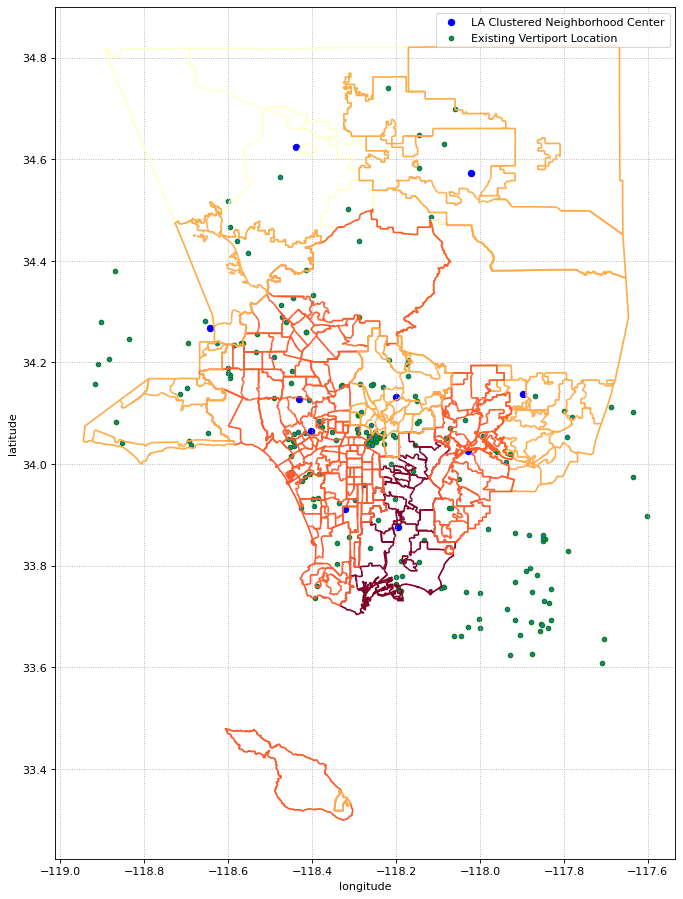

In [31]:
df['label']=kmeans_10.labels_

df_pre_dissolve = geopandas.GeoDataFrame(df, geometry=df['boundary'])
df_dissolve = df[['geometry', 'total_pop', 'label']].dissolve(by='label', aggfunc='sum')
# df_dissolve = df_dissolve.to_crs('EPSG:3395')
df_dissolve['centroid'] = df_dissolve.centroid

fig, ax = plt.subplots(figsize=(10,15), dpi=80)
df_dissolve.plot(ax=ax,column = 'total_pop', scheme='Percentiles', cmap='YlOrRd')
df_dissolve_c = geopandas.GeoDataFrame(df_dissolve)
df_dissolve_c['geometry'] = df_dissolve_c['centroid']
df_dissolve_c.plot(ax=ax, color='blue', markersize=32, label='LA Clustered Neighborhood Center')
ax.scatter(df_vertiport_la['SHAPE_X'], df_vertiport_la['SHAPE_Y'], s=16, edgecolors='green', label='Existing Vertiport Location')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.legend()
ax.grid(linestyle=':')

In [38]:
df_dissolve_c.explore()